In [1]:
!pip install geobr
!pip install mapsmx
!pip install plotly
!pip install geopandas
!pip install nltk
!pip install googletrans
!pip install wordcloud
!pip install xgboost

## Imports

In [2]:
import os
import time
import pandas as pd
import numpy as np
import re
import string
from scipy import stats
from random import sample
from collections import Counter
from PIL import Image

# Plotting Libraries
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_theme(context="notebook", style="darkgrid", palette="pastel")

# Geospacial Libraries
import geobr
import mapsmx as mp
import plotly.express as px
import geopandas as gpd

# NLP Libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from googletrans import Translator
from wordcloud import WordCloud

# sklearn
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

# torch
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# XGBoost
import xgboost as xgb

In [3]:
seed = 42

## Carregando o dataset

In [4]:
def load_data(data_path):
    return pd.read_parquet(data_path)
products_file = 'data/olist_products_dataset.parquet'
orders_file = 'data/olist_orders_dataset.parquet'
order_items_file = 'data/olist_order_items_dataset.parquet'
order_payments_file = 'data/olist_order_payments_dataset.parquet'
customers_file = 'data/olist_customers_dataset.parquet'
geolocation_file = 'data/olist_geolocation_dataset.parquet'
reviews_file = 'data/olist_order_reviews_dataset.parquet'
sellers_file = 'data/olist_sellers_dataset.parquet'
category_file = 'data/product_category_name_translation.parquet'

products_df = load_data(products_file)
orders_df = load_data(orders_file)
order_items_df = load_data(order_items_file)
order_payments_df = load_data(order_payments_file)
order_reviews_df = load_data(reviews_file)
customers_df = load_data(customers_file)
geolocation_df = load_data(geolocation_file)
sellers_df = load_data(sellers_file)
category_df = load_data(category_file)

# Merge nos dados
full_df = orders_df.merge(order_reviews_df, on='order_id')\
                   .merge(order_payments_df, on='order_id')\
                   .merge(customers_df, on='customer_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')

# Tirando as duplicatas
full_df = full_df.drop_duplicates()

# Removendo os comentários vazios
full_df = full_df.dropna(subset=['review_comment_message'])

## Resumo do Dataframe -> Pré-Processamento

###### Usamos a função `df_summary` para dar uma olhada nos nossos dados de forma geral. Ela é mais informativa e legível do que a função `DataFrame.info()` fornecida pelo Pandas. Também usaremos isso para checar nossos dados após o pré-processamento.

In [5]:
def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

df_summary(full_df)

Dataset Shape: (49679, 39)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,40311,e481f51cbdc54678b7cc49136f2d6af7,15.14
1,customer_id,object,0,40311,9ef432eb6251297304e76186b10a928d,15.14
2,order_status,object,0,6,delivered,0.26
3,order_purchase_timestamp,object,0,40188,2017-10-02 10:56:33,15.14
4,order_approved_at,object,8,38748,2017-10-02 11:07:15,15.07
5,order_delivered_carrier_date,object,823,36015,2017-10-04 19:55:00,14.92
6,order_delivered_customer_date,object,1585,38810,2017-10-10 21:25:13,15.09
7,order_estimated_delivery_date,object,0,437,2017-10-18 00:00:00,8.48
8,review_id,object,0,40179,a54f0611adc9ed256b57ede6b6eb5114,15.14
9,review_score,int64,0,5,4,1.95


### Convertendo tipos de dados e corrigindo nomes imppróprios pras colunas

In [6]:
datetime_columns = ['order_purchase_timestamp', 'order_approved_at',
                    'order_delivered_carrier_date', 'order_delivered_customer_date',
                    'order_estimated_delivery_date',
                    'review_creation_date', 'review_answer_timestamp',
                    'shipping_limit_date']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

In [7]:
full_df = full_df.rename(columns={'product_name_lenght': 'product_name_length',
                                   'product_description_lenght': 'product_description_length'
                                  })

In [8]:
df_summary(full_df)

Dataset Shape: (49679, 39)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,40311,e481f51cbdc54678b7cc49136f2d6af7,15.14
1,customer_id,object,0,40311,9ef432eb6251297304e76186b10a928d,15.14
2,order_status,object,0,6,delivered,0.26
3,order_purchase_timestamp,datetime64[ns],0,40188,2017-10-02 10:56:33,15.14
4,order_approved_at,datetime64[ns],8,38748,2017-10-02 11:07:15,15.07
5,order_delivered_carrier_date,datetime64[ns],823,36015,2017-10-04 19:55:00,14.92
6,order_delivered_customer_date,datetime64[ns],1585,38810,2017-10-10 21:25:13,15.09
7,order_estimated_delivery_date,datetime64[ns],0,437,2017-10-18 00:00:00,8.48
8,review_id,object,0,40179,a54f0611adc9ed256b57ede6b6eb5114,15.14
9,review_score,int64,0,5,4,1.95


In [9]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

analyzer = SentimentIntensityAnalyzer()
full_df['comp_score'] = full_df['review_comment_message'].apply(lambda review: analyzer.polarity_scores(str(review))['compound'] if not pd.isna(review) else None)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# EDA para Classificação

## Correlações

##### Primeiro de tudo, encontramos correlação em nosso conjunto de dados. Essa etapa é importante porque pode nos ajudar a identificar relacionamentos entre diferentes variáveis. Variáveis correlacionadas podem nos ajudar a raciocinar sobre possíveis causas e efeitos.

##### Os dados contêm colunas de diferentes tipos. Para a análise de correlação, focamos nas colunas numéricas. Então, precisamos primeiro filtrar as colunas numéricas.

In [10]:
numeric_columns = ['review_score', 'payment_sequential', 'payment_installments',
                   'payment_value', 'price', 'freight_value', 'product_name_length',
                   'product_description_length', 'product_photos_qty', 'product_weight_g',
                   'product_length_cm', 'product_height_cm', 'product_width_cm']
numeric_df = full_df[numeric_columns]
corr = numeric_df.corr()

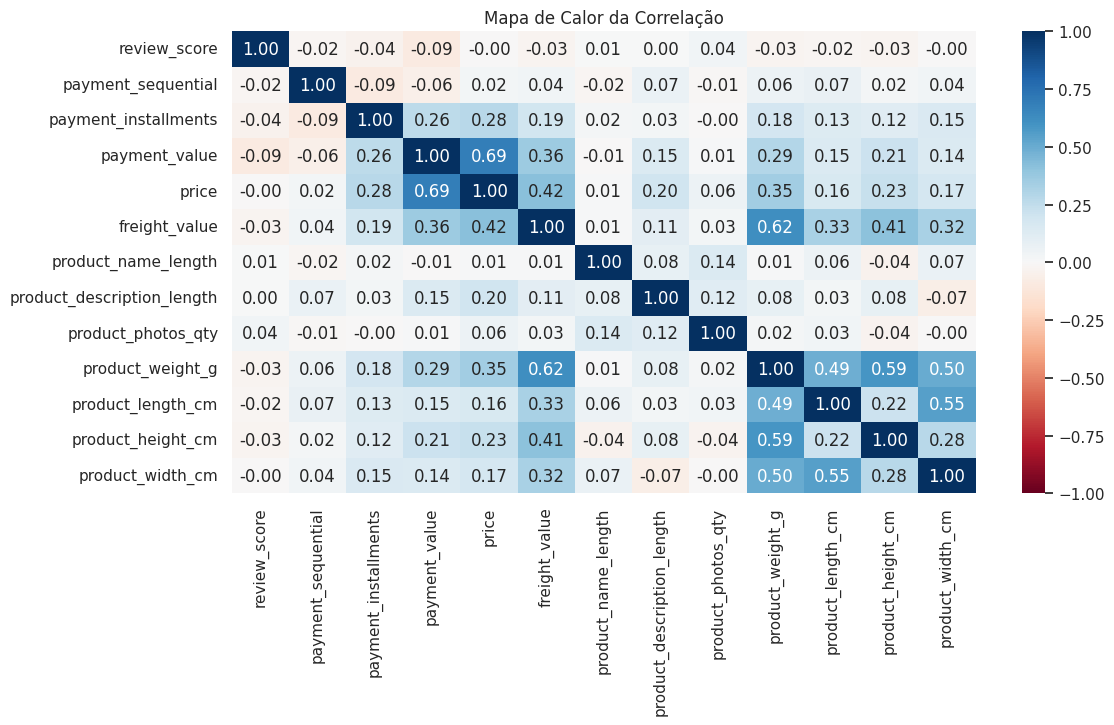

In [11]:
plt.figure(figsize=(12, 6))
sns.heatmap(corr, cmap='RdBu', norm=plt.Normalize(-1,1), annot=True, fmt='.2f')
plt.title("Mapa de Calor da Correlação")
plt.show()

## Correlation analysis of payment value

##### Usamos limiares de 0,3 e -0,3 para filtrar as características que estão mais correlacionadas com o valor do pagamento. Como mostrado abaixo, o preço, o valor do frete (custo de transporte e entrega) e o peso do produto são os que mais se correlacionam com o valor do pagamento. Esse resultado está em linha com o nosso bom senso: o preço e o custo de entrega são claramente os principais componentes do pagamento; o peso do produto é um dos principais determinantes do custo de transporte. Portanto, a mudança nessas características pode afetar bastante o valor do pagamento.

In [12]:
corr_payment_value = corr.loc[(corr['payment_value'] > 0.3) | (corr['payment_value'] <= -0.3)]
corr_payment_value

,review_score,payment_sequential,payment_installments,payment_value,price,freight_value,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
payment_value,-0.090726,-0.057375,0.257895,1.000000,0.691278,0.359784,-0.006300,0.145576,0.010925,0.293154,0.145775,0.211501,0.143628
price,-0.000369,0.024451,0.276662,0.691278,1.000000,0.416671,0.008740,0.201763,0.058824,0.348664,0.160907,0.230789,0.174392
freight_value,-0.031045,0.038456,0.187715,0.359784,0.416671,1.000000,0.012424,0.106943,0.026473,0.621384,0.327853,0.407240,0.321235


##### Usamos as colunas price, freight_value e product_weight_g para criar pairplots e visualizar a relação delas com o valor do pagamento. Como o conjunto de dados é muito grande para caber em um único gráfico, decidimos pegar aleatoriamente 500 amostras do conjunto. Assim, temos um tempo de execução razoável para plotar, enquanto ainda conseguimos visualizar a tendência geral e as relações das características. Para melhorar a qualidade da visualização e a legibilidade, removemos os outliers nas colunas. Os gráficos estão mais aproximados das regiões onde os pontos de dados estão mais densamente agrupados. Também convertamos a unidade do peso do produto de gramas para quilogramas, assim os marcadores ficam menores e mais fáceis de entender.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


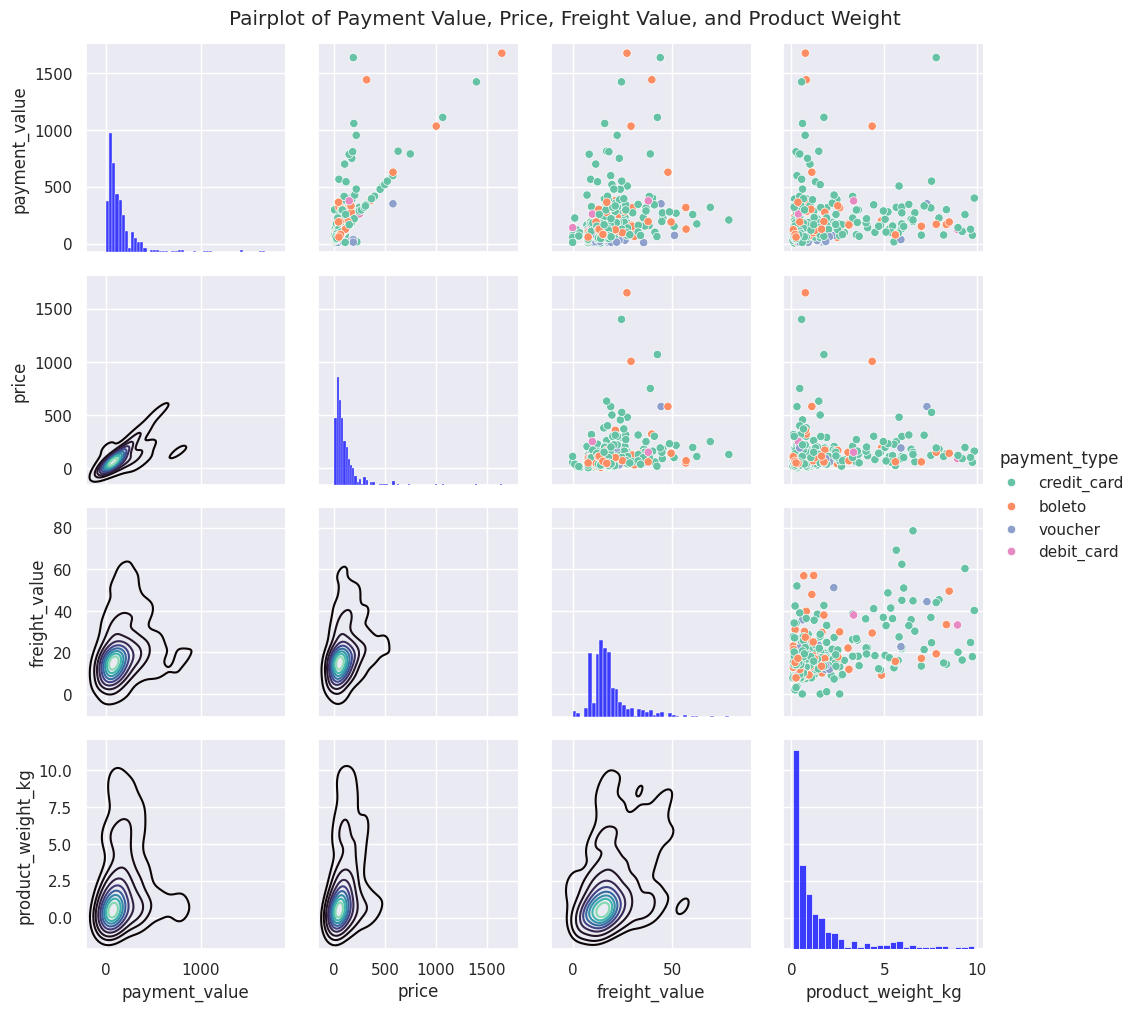

In [13]:
# Randomly sample 500 data points
full_df_sample = full_df.sample(500, random_state=seed)

# Convent product weight's unit from grams to kilograms
full_df_sample['product_weight_g'] = full_df_sample['product_weight_g'].apply(lambda x: x/1000)
full_df_sample = full_df_sample.rename(columns={'product_weight_g': 'product_weight_kg'})

# Remove outliers in payment_value
payment_value_q99 = full_df_sample['payment_value'].quantile(0.99)
full_df_sample = full_df_sample[full_df_sample['payment_value'] < payment_value_q99]

# Remove outliers in freight_value
freight_value_q99 = full_df_sample['freight_value'].quantile(0.99)
full_df_sample = full_df_sample[full_df_sample['freight_value'] < freight_value_q99]

# Remove outliers in product_weight
product_weight_q95 = full_df_sample['product_weight_kg'].quantile(0.95)
full_df_sample = full_df_sample[full_df_sample['product_weight_kg'] < product_weight_q95]

# Pairplot
g = sns.PairGrid(full_df_sample, hue='payment_type',
                 vars=['payment_value', 'price', 'freight_value', 'product_weight_kg'],
                 palette='Set2')
g.map_upper(sns.scatterplot)
g.map_diag(sns.histplot, hue=None, color='blue')
g.map_lower(sns.kdeplot, hue=None, cmap = sns.color_palette("mako", as_cmap=True))
g.add_legend()
g.fig.suptitle('Pairplot of Payment Value, Price, Freight Value, and Product Weight', y=1.01)
plt.show()

## Status de Entrega

##### A partir das informações no status do pedido, podemos saber em qual etapa os clientes estão. Além de "entregue", que é a etapa final nesse sistema de status de pedidos, existem etapas como "enviado", "cancelado", etc. Essas informações sobre o status do pedido podem ser significativas e se tornar um dos fatores que influenciam as notas dos avaliadores. Para status como "cancelado" ou "indisponível", isso pode prejudicar a experiência do usuário e, consequentemente, diminuir as avaliações. Além disso, quando o status mostra "enviado", "em processamento" ou qualquer outra etapa de pré-processamento, podem ocorrer alguns erros que impedem o andamento do pedido e o impede de ser marcado como "entregue". Portanto, analisamos as notas médias de avaliação para esses pedidos não entregues abaixo.

In [14]:
shipped_review_mean = full_df[full_df['order_status'] == 'shipped']['review_score'].mean(axis=0)
canceled_review_mean = full_df[full_df['order_status'] == 'canceled']['review_score'].mean(axis=0)
invoiced_review_mean = full_df[full_df['order_status'] == 'invoiced']['review_score'].mean(axis=0)
processing_review_mean = full_df[full_df['order_status'] == 'processing']['review_score'].mean(axis=0)
unavailable_review_mean = full_df[full_df['order_status'] == 'unavailable']['review_score'].mean(axis=0)
approved_review_mean = full_df[full_df['order_status'] == 'approved']['review_score'].mean(axis=0)

print(f'The mean review score for "shipped" order is {shipped_review_mean}')
print(f'The mean review score for "canceled" order is {canceled_review_mean}')
print(f'The mean review score for "invoiced" order is {invoiced_review_mean}')
print(f'The mean review score for "processing" order is {processing_review_mean}')
print(f'The mean review score for "unavailable" order is {unavailable_review_mean}')
print(f'The mean review score for "approved" order is {approved_review_mean}')

The mean review score for "shipped" order is 1.6746143057503506
The mean review score for "canceled" order is 1.4108108108108108
The mean review score for "invoiced" order is 1.38671875
The mean review score for "processing" order is 1.2768595041322315
The mean review score for "unavailable" order is 1.0
The mean review score for "approved" order is nan


<ipython-input-15-d2c9134bb9f1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  order_status_plot = sns.countplot(x='order_status', data=full_df[order_status_columns], ax=axes[0], palette=("Blues_d"))
<ipython-input-15-d2c9134bb9f1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  order_status_plot_med = sns.countplot(x='order_status', data=full_df[order_status_columns], ax=axes[1], palette=("Blues_d"))
<ipython-input-15-d2c9134bb9f1>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  order_status_plot_smaller = sns.countplot(x='order_status', data=full_df[order_status_columns

Text(0.5, 0.98, 'Ocorrência do Status de Entrega')

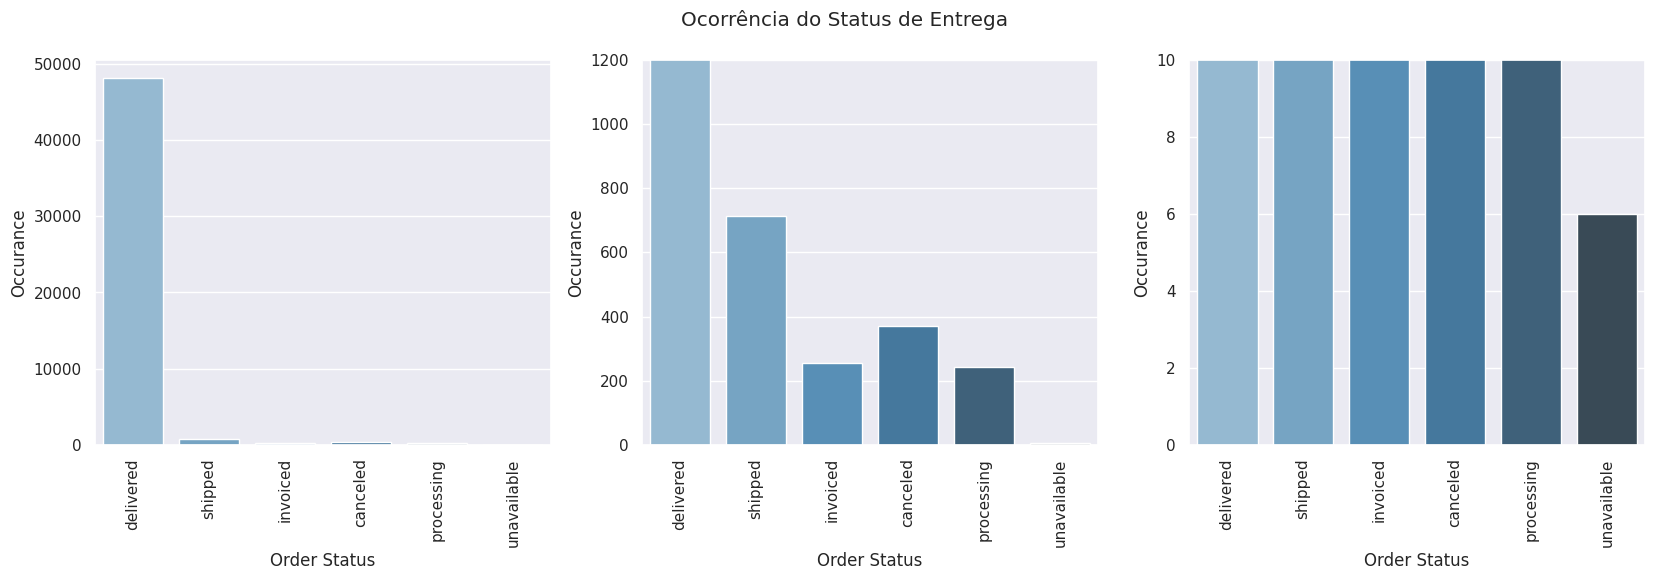

In [15]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(20,5))
order_status_columns = ['order_id', 'order_status']

order_status_plot = sns.countplot(x='order_status', data=full_df[order_status_columns], ax=axes[0], palette=("Blues_d"))
order_status_plot.set(xlabel = 'Order Status', ylabel='Occurance', ylim=(0, None))
order_status_plot.tick_params(axis='x', rotation=90)

order_status_plot_med = sns.countplot(x='order_status', data=full_df[order_status_columns], ax=axes[1], palette=("Blues_d"))
order_status_plot_med.set(xlabel='Order Status', ylabel='Occurance', ylim=(0, 1200))
order_status_plot_med.tick_params(axis='x', rotation=90)

order_status_plot_smaller = sns.countplot(x='order_status', data=full_df[order_status_columns], ax=axes[2], palette=("Blues_d"))
order_status_plot_smaller.set(xlabel='Order Status', ylabel='Occurance', ylim=(0, 10))
order_status_plot_smaller.tick_params(axis='x', rotation=90)

fig.suptitle('Ocorrência do Status de Entrega')

## Análise Geográfica

##### São Paulo tem mais de 40 mil clientes, mais do que qualquer outro estado. Pertinho, o Rio de Janeiro e Minas Gerais também têm cerca de 10 mil usuários. As cidades mais populares estão concentradas perto do porto. Os clientes de e-commerce estão quase uniformemente distribuídos pelos outros estados.

In [16]:
#states["abbrev_state"] = states["abbrev_state"].str.lower()
#customers_df_state=customers_df.groupby(by='customer_state')[['customer_id']].count().reset_index()
#customers_df_state['customer_state'] = customers_df_state['customer_state'].str.lower()

# join geo with data
#states_n = states.merge(customers_df_state, left_on="abbrev_state", right_on="customer_state")
#states_n=states_n.rename(columns={'customer_id':'Numbers'})
#fig = px.choropleth(states_n, geojson=states_n['geometry'],
                    #locations=states_n.index, color="Numbers",
                    #height=500,
                    #hover_name='abbrev_state',
                    #labels = {'name_state' : 'Numbers'},
                    #title = 'Numbers of customers across states',
                   #color_continuous_scale="Viridis")
#fig.update_geos(fitbounds="locations", visible=True)
#fig.update_layout(
    #title={'text':'Numbers of customers across states',
            #'x':0.5,
            #'xanchor': 'center'}
#)
#fig.show()

## NLP nas `review_comment_message`'s

##### No dataframe, podemos observar muitos dados de texto que podem ser valiosos para análise. Vamos dividir o conteúdo da coluna em uma lista de palavras e usaremos a biblioteca nltk para facilitar o processamento do texto.

##### Limpando a coluna `review_comment_message` para substituir valores vazios ou inválidos, como NaN, para análise.

In [17]:
full_df[['review_comment_message']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 49679 entries, 0 to 117314
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_comment_message  49679 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


##### Para poder analisar as mensagens dos comentários que recebemos, precisamos remover os valores nulos primeiro:

In [18]:
review_comment_message_dropna = full_df['review_comment_message'].dropna()
review_comment_message_dropna

,review_comment_message
0,"Não testei o produto ainda, mas ele veio corre..."
1,"Não testei o produto ainda, mas ele veio corre..."
2,"Não testei o produto ainda, mas ele veio corre..."
3,Deveriam embalar melhor o produto. A caixa vei...
4,"Só achei ela pequena pra seis xícaras ,mais é ..."
...,...
117308,"Ainda não recebi meu produto, espero uma respo..."
117309,"Ainda não recebi meu produto, espero uma respo..."
117310,Ainda aguardo o produto. Após recebimento ou p...
117312,Tudo certo!


##### Com os dados limpos, podemos começar a usar a biblioteca nltk e avaliar o conteúdo da mensagem

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
# Importando a biblioteca 'stopwords'
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_pt = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Usando a função `tokenize_content` para tokenizar as frases da avaliação para uma análise posterior

In [21]:
def tokenize_content(content):
  words = [word.lower() for word in nltk.word_tokenize(content) if word.isalpha()]
  words = [word for word in words if word not in stopwords_pt]
  return words

In [22]:
reviews = review_comment_message_dropna.tolist()
top_tokens_list = []

# Create top_tokens_list for all words in reviews
for review in reviews:
  token_words = tokenize_content(review)
  top_tokens_list.append(token_words)

top_tokens = [item for sublist in top_tokens_list for item in sublist]

##### Computando a lista `top_most_common` para mostrar as palavras que aparecem com mais frequência nos comentários das avaliações

In [23]:
cnt = Counter()

# Contando as occurances das palavras
for word in top_tokens:
  cnt[word] += 1

top_most_common = sorted(cnt.items(), key=lambda item: -item[1])[:100]

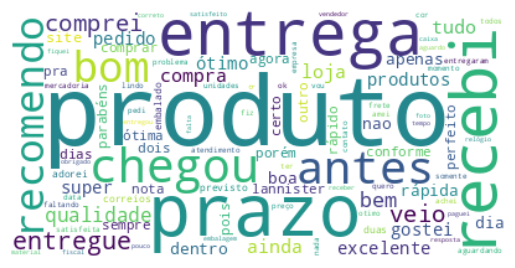

In [24]:
span_freq_dict = {}

# Creat top most common words dict with frequencies
for i in top_most_common:
  # Ignore the word if it is in stopwords in english
  span_freq_dict[i[0]] = i[1]

wc = WordCloud(background_color='white')
wc.generate_from_frequencies(span_freq_dict)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

##### Como as mensagens estão em português, nos passos seguintes, traduzimos as mais comuns para o inglês e criamos uma nuvem de palavras correspondente em inglês para uma leitura melhor

In [25]:
#translator = Translator()
#top_most_common_en = list(map(lambda x: (translator.translate(x[0], dest="portuguese").text, x[1]), top_most_common))

## Feature Engineering

##### Resolvendo a desarmonia do `review_score`

##### A partir dos dados de `review_score` e do gráfico abaixo, podemos notar que há um desequilíbrio entre os scores, onde o score 5 tem muito mais contagens em comparação com os outros scores. Para lidar com isso, tentamos combinar alguns dos scores e tornamos o `review_score` categórico, o que pode diminuir o desequilíbrio.

##### Criando uma coluna chamada `review_score_factor`, que pode conter 3 valores (0, 1, 2) que representam, respectivamente, baixo (scores 1, 2), médio (scores 3, 4) e alto (score 5) na seguinte forma:

In [26]:
print("review_score == 5: %d" % len(full_df[full_df['review_score']==5]))
print("review_score == 4: %d" % len(full_df[full_df['review_score']==4]))
print("review_score == 3: %d" % len(full_df[full_df['review_score']==3]))
print("review_score == 2: %d" % len(full_df[full_df['review_score']==2]))
print("review_score == 1: %d" % len(full_df[full_df['review_score']==1]))
score_list = [len(full_df[full_df['review_score']==1]),
              len(full_df[full_df['review_score']==2]),
              len(full_df[full_df['review_score']==3]),
              len(full_df[full_df['review_score']==4]),
              len(full_df[full_df['review_score']==5])]

review_score == 5: 23645
review_score == 4: 7086
review_score == 3: 4505
review_score == 2: 2882
review_score == 1: 11561


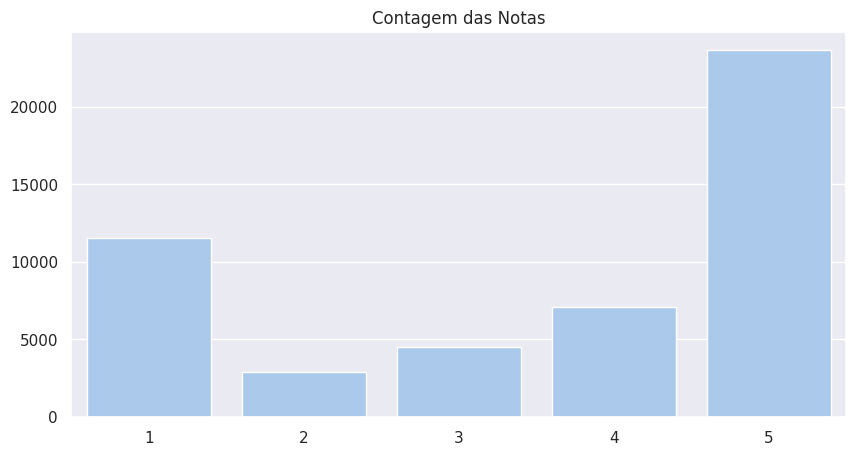

In [27]:
plt.figure(figsize=(10,5))
chart = sns.barplot(x=[1,2,3,4,5], y=score_list)
chart.set(title="Contagem das Notas")
plt.show()

In [28]:
# Clonando `full_df` pro `feature_df` pra ser usando nos modelos futuros
feature_df = full_df

# Amontoando os `review_score`s
feature_df.loc[feature_df['review_score'] == 5, "review_score_factor"] = 2
feature_df.loc[feature_df['review_score'] <= 4, "review_score_factor"] = 1
feature_df.loc[feature_df['review_score'] <= 2, "review_score_factor"] = 0

In [29]:
feature_df['review_score_factor']

,review_score_factor
0,1.0
1,1.0
2,1.0
3,1.0
4,2.0
...,...
117308,0.0
117309,0.0
117310,0.0
117312,1.0


### Mudando `price` e `freight_value` para valor categórico, pra facilitar a leitura da máquina

In [30]:
price_median = feature_df['price'].median();
feature_df.loc[feature_df['price'] >= price_median, "price_factor"] = 1
feature_df.loc[feature_df['price'] < price_median, "price_factor"] = 0

In [31]:
freight_value_median = feature_df['freight_value'].median();
feature_df.loc[feature_df['freight_value'] >= freight_value_median, "freight_value_factor"] = 1
feature_df.loc[feature_df['freight_value'] < freight_value_median, "freight_value_factor"] = 0

### Determinar se o pacote foi `delivered` ou não

In [32]:
feature_df.loc[feature_df['order_status'] == 'delivered', "if_delivered"] = 1
feature_df.loc[feature_df['order_status'] != 'delivered', "if_delivered"] = 0

### Diferenças entre data de entrega estimada e atual

In [33]:
# Check how many rows in non_delivered records don't have data in `order_delivered_customer_date`
non_delivered = feature_df[feature_df['if_delivered'] == 0]
nan_delivered_customer_count = non_delivered[non_delivered['order_delivered_customer_date'].isnull()]['order_id'].count()
print(f'There are {nan_delivered_customer_count} rows isnull in order_delivered_customer_date column for all non_delivered rows')

There are 1580 rows isnull in order_delivered_customer_date column for all non_delivered rows


In [34]:
feature_df.loc[feature_df['order_delivered_customer_date'].isnull(), "order_delivered_customer_date"] = feature_df['order_estimated_delivery_date']

In [35]:
# Mantendo a diferença em dias na coluna
feature_df['actual_est_delivery_diff'] = (feature_df['order_estimated_delivery_date'] - feature_df['order_delivered_customer_date']).dt.days

### Finalmente, contabilizando quantos dias demoraram pra receber o pacote

In [36]:
feature_df['delivery_duration'] = (feature_df['order_delivered_customer_date'] - feature_df['order_purchase_timestamp']).dt.days

##### Definindo o `product_photos_qty` e `product_description_length` como 0 por padrão se o registro original for nulo aqui.

##### Removemos a linha se ela não tiver um peso.

In [37]:
feature_df.loc[feature_df['product_photos_qty'].isnull(), "product_photos_qty"] = 0
feature_df.loc[feature_df['product_description_length'].isnull(), "product_description_length"] = 0
feature_df = feature_df.dropna(subset=['product_weight_g'])

##### Ao listar o nome da categoria do produto, percebemos que algumas linhas no full_df não têm nenhuma informação sobre nome do produto, categoria do produto, descrição do produto e fotos do produto. Essas linhas podem ser erros ou dados de teste que não fazem sentido. Portanto, antes de fazermos a codificação one-hot da categoria do produto, limpamos o dataframe removendo as linhas que não têm nome do produto.

In [38]:
feature_df = feature_df.dropna(subset=['product_name_length'])

In [39]:
#feature_df.to_parquet('data/feature_df.parquet')

In [40]:
#df_summary(feature_df)

In [41]:
feature_df[['review_comment_message','comp_score', 'review_score', 'review_score_factor']].sort_values(by='comp_score', ascending=False)

,review_comment_message,comp_score,review_score,review_score_factor
25045,"Produtos lindos super da hora, chegaram em men...",0.9136,5,2.0
24954,"Produtos lindos super da hora, chegaram em men...",0.9136,5,2.0
82546,Adoreiii os capachos! super lindos <3 A entreg...,0.8748,5,2.0
82572,Adoreiii os capachos! super lindos <3 A entreg...,0.8748,5,2.0
117137,"Entrega super rápida, a mercadoria chegou muit...",0.8741,5,2.0
...,...,...,...,...
82586,MAS ACHO QUE TALVEZ NÃO FOI ENTRGUE NO PRAZO!!...,-0.8740,5,2.0
111302,Comprei 3 Whey Protein e 1 Hemo Rage no mesmo ...,-0.9039,1,0.0
82301,Comprei 3 Whey Protein e 1 Hemo Rage no mesmo ...,-0.9039,1,0.0
82303,Comprei 3 Whey Protein e 1 Hemo Rage no mesmo ...,-0.9039,1,0.0
